In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
mp_key = "7T8Rm9ppE58YHsBs2IkJCMwMXshrwbpx"
mp_id = "mp-1018096"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Capacités calorifiques

Le modèle d'Einstein fait l'hypothèse que toutes les fréquences sont égales à une fréquence naturelle $\omega_E$. Selon ce modèle, la capacité calorifique suit l'équation : $C_v = 3N_{at}R(\frac{\Theta_E}{T})^2 \frac{e^{\Theta_E/T}}{(e^{\Theta_E/T}-1)^2}$.

Le modèle de Debye suppose que toutes les fréquences ont la même dispersion linéaire. Dans ce modèle, la capacité calorifique s'écrit : $C_v = 9 N_{at} R \left( \frac{T}{\Theta_D} \right)^3 \int_0^{\Theta_D / T} \frac{x^4 e^x}{(e^x - 1)^2} \, dx$


In [4]:
temperatures = np.arange(5,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)

In [5]:
# Modèle d'Einstein
def CvE(T,Theta_E):
    return 3*nat*R*((Theta_E/T)**2)*(np.exp(Theta_E/T))/((np.exp(Theta_E/T)-1)**2)

# Modèle de Debye
def CvD(T, Theta_D):
    integrand = lambda x: ((x**4) * np.exp(x)) / ((np.exp(x) - 1)**2)
    integral, _ = quad(integrand, 0, Theta_D / T)
    return 9*nat*R*((T/Theta_D)**3)*integral

# Fonction d'erreur pour Einstein
def error_Einstein(Theta_E):
    return np.sum([(ph_cv[i] * 3 * nat * R - CvE(T, Theta_E))**2 for i, T in enumerate(temperatures)])

# Fonction d'erreur pour Debye
def error_Debye(Theta_D):
    return np.sum([(ph_cv[i] * 3 * nat * R - CvD(T, Theta_D))**2 for i, T in enumerate(temperatures)])

# Minimisation pour le modèle d'Einstein
result_E = minimize(error_Einstein, x0=np.array([200]), bounds=[(1, 1000)])
Theta_E_opt = result_E.x[0]

# Minimisation pour le modèle de Debye
result_D = minimize(error_Debye, x0=np.array([200]), bounds=[(1, 1000)])
Theta_D_opt = result_D.x[0]

print(f"Température d'Einstein optimale: {Theta_E_opt:.2f} K")
print(f"Température de Debye optimale: {Theta_D_opt:.2f} K")


Température d'Einstein optimale: 182.40 K
Température de Debye optimale: 247.81 K


### Courbes

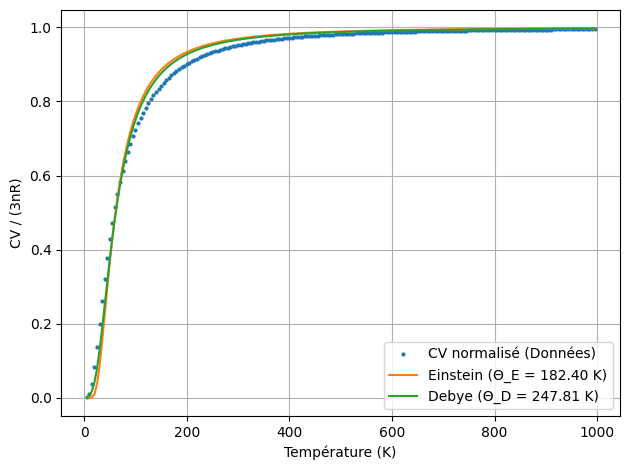

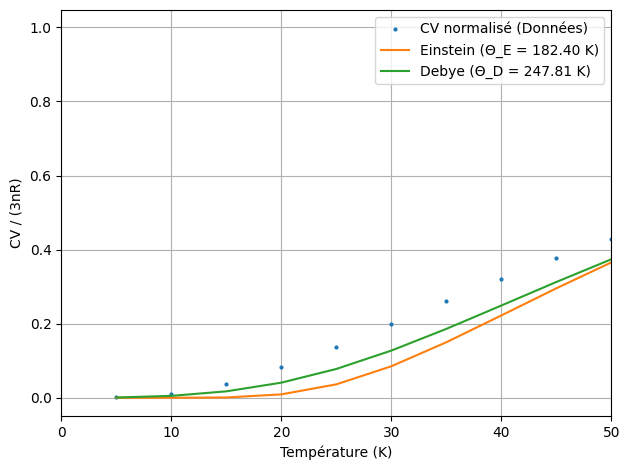

In [6]:
# Tracé
plt.plot(temperatures, ph_cv, label='CV normalisé (Données)',linestyle = '', marker="o", markersize =2)
plt.plot(temperatures, CvE(temperatures, Theta_E_opt) / (3 * nat * R), label=f'Einstein (Θ_E = {Theta_E_opt:.2f} K)')
plt.plot(temperatures, [CvD(T, Theta_D_opt) / (3 * nat * R) for T in temperatures], label=f'Debye (Θ_D = {Theta_D_opt:.2f} K)')
plt.xlabel("Température (K)")
plt.ylabel("CV / (3nR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(temperatures, ph_cv, label='CV normalisé (Données)',linestyle = '', marker="o", markersize =2)
plt.plot(temperatures, CvE(temperatures, Theta_E_opt) / (3 * nat * R), label=f'Einstein (Θ_E = {Theta_E_opt:.2f} K)')
plt.plot(temperatures, [CvD(T, Theta_D_opt) / (3 * nat * R) for T in temperatures], label=f'Debye (Θ_D = {Theta_D_opt:.2f} K)')
plt.xlabel("Température (K)")
plt.ylabel("CV / (3nR)")
plt.legend()
plt.grid(True)
plt.xlim(0, 50) 
plt.tight_layout()
plt.show()

Le modèle d'Einstein fonctionne moins bien que celui de Debye pour les températures plus basses. Cela s'explique par son hypothèse sur la fréquence naturelle que celle de Debye qui considère une identique dispersion linéaire.

### Densité d'états de phonons

Dans le modèle d'Einstein, la densité de modes normaux est donnée par : $g_E(\omega) = 3N_{at} \delta(\omega-\omega_E)$. Tandis que dans celui de Debye : $g_{D}(\omega) =$ \begin{cases} \frac{3 N_{at} \Omega \omega^2}{2 \pi^2 v^3} & \text{pour } \omega < \omega_D = v q_D \\
0 & \text{pour } \omega > \omega_D
\end{cases}


In [7]:
hbar = 1.05457266e-34 # [Js]
kB = 1.380649e-23 # [J/K]
wE = kB*Theta_E_opt/hbar*1e-12 # [Trad/s]
wD = kB*Theta_D_opt/hbar*1e-12 # [Trad/s]
Omega = prim_struc.volume # [1/A^3]
qD = ((6*(np.pi**2)*nat)/Omega)**(1/3) # [1/A]
v = wD/qD # A/s

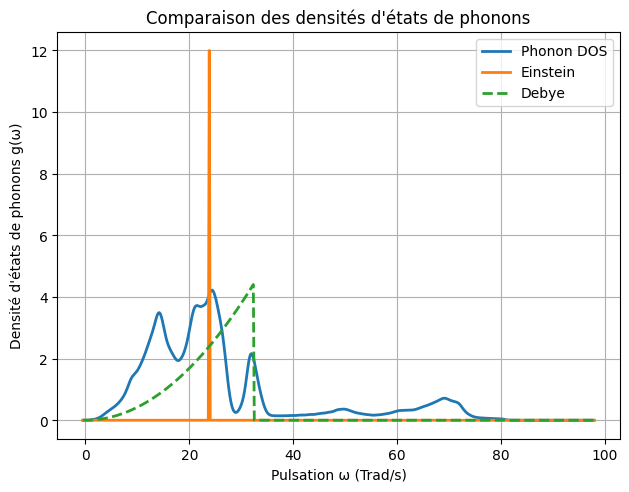

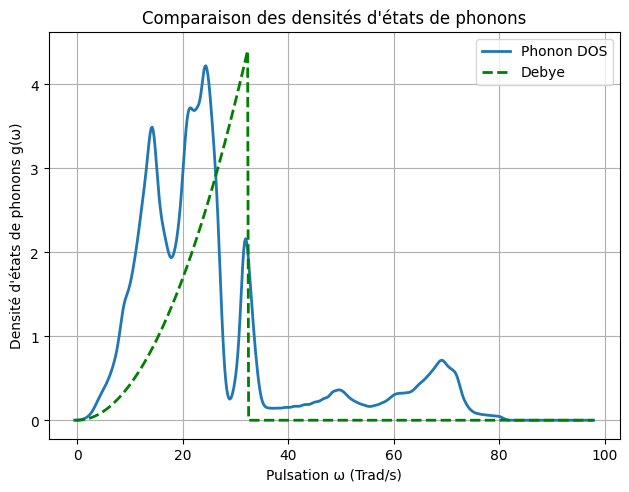

In [8]:
frequencies_THz = ph_dos.frequencies
w = 2 * np.pi * frequencies_THz  # [Trad/s]
g = ph_dos.densities

# Einstein
gE = np.zeros_like(w)
gE[np.argmin(np.abs(w - wE))] = 3 * nat


# Debye
gD = np.zeros_like(w)
mask = w < wD
gD[mask] = (3 * nat * Omega * (w[mask]**2)) / (2 * (np.pi**2) * v**3) 


# Tracé
plt.plot(w, g, label="Phonon DOS", linewidth=2)
plt.plot(w, gE, '-', label="Einstein", linewidth=2)
plt.plot(w, gD, '--', label="Debye", linewidth=2)
plt.xlabel("Pulsation ω (Trad/s)")
plt.ylabel("Densité d'états de phonons g(ω)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.title("Comparaison des densités d'états de phonons")
plt.show()

plt.plot(w, g, label="Phonon DOS", linewidth=2)
plt.plot(w, gD, '--', label="Debye", linewidth=2, color = 'green')
plt.xlabel("Pulsation ω (Trad/s)")
plt.ylabel("Densité d'états de phonons g(ω)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.title("Comparaison des densités d'états de phonons")
plt.show()

Les deux modèles sont de grosses approximations. Cependant si on intègre $g_E(\omega)$, on tombe bien sur $3N_{at}$, le nombre total de modes normaux. Quant à l'approximation de Debye, qui suppose une évolution quadratique, nous avons que l'aire sous la courbe est égale à celle expérimentale grâce au choix de $q_D$. 